In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import numpy as np

import plotly.graph_objects  as go

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

import os
import re 
from tqdm import tqdm 

In [2]:
df = pd.read_csv('../data/frame2.csv')

c:\Users\maksk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<AxesSubplot:>

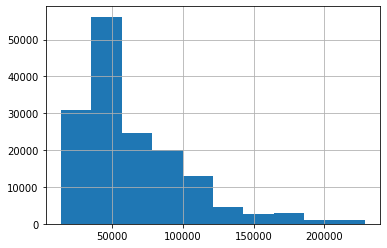

In [3]:
df['salary_from_rate_and_gross'].hist()

In [4]:
buckets = list(np.arange(-1, 250_000+10_000, 10_000)) + [np.inf]
buckets = pd.DataFrame(np.vstack([buckets[:-1], buckets[1:]])).T.values

In [5]:
buckets

array([[-1.00000e+00,  9.99900e+03],
       [ 9.99900e+03,  1.99990e+04],
       [ 1.99990e+04,  2.99990e+04],
       [ 2.99990e+04,  3.99990e+04],
       [ 3.99990e+04,  4.99990e+04],
       [ 4.99990e+04,  5.99990e+04],
       [ 5.99990e+04,  6.99990e+04],
       [ 6.99990e+04,  7.99990e+04],
       [ 7.99990e+04,  8.99990e+04],
       [ 8.99990e+04,  9.99990e+04],
       [ 9.99990e+04,  1.09999e+05],
       [ 1.09999e+05,  1.19999e+05],
       [ 1.19999e+05,  1.29999e+05],
       [ 1.29999e+05,  1.39999e+05],
       [ 1.39999e+05,  1.49999e+05],
       [ 1.49999e+05,  1.59999e+05],
       [ 1.59999e+05,  1.69999e+05],
       [ 1.69999e+05,  1.79999e+05],
       [ 1.79999e+05,  1.89999e+05],
       [ 1.89999e+05,  1.99999e+05],
       [ 1.99999e+05,  2.09999e+05],
       [ 2.09999e+05,  2.19999e+05],
       [ 2.19999e+05,  2.29999e+05],
       [ 2.29999e+05,  2.39999e+05],
       [ 2.39999e+05,  2.49999e+05],
       [ 2.49999e+05,  2.59999e+05],
       [ 2.59999e+05,          inf]])

In [7]:
model = CatBoostClassifier().load_model('../app/model/base.cbm')
print(model.classes_)

['[109999.0, 119999.0)' '[119999.0, 129999.0)' '[129999.0, 139999.0)'
 '[139999.0, 149999.0)' '[149999.0, 159999.0)' '[159999.0, 169999.0)'
 '[169999.0, 179999.0)' '[179999.0, 189999.0)' '[189999.0, 199999.0)'
 '[19999.0, 29999.0)' '[199999.0, 209999.0)' '[209999.0, 219999.0)'
 '[219999.0, 229999.0)' '[29999.0, 39999.0)' '[39999.0, 49999.0)'
 '[49999.0, 59999.0)' '[59999.0, 69999.0)' '[69999.0, 79999.0)'
 '[79999.0, 89999.0)' '[89999.0, 99999.0)' '[9999.0, 19999.0)'
 '[99999.0, 109999.0)']


In [ ]:
'[19999.0, 29999.0)',
'[209999.0, 219999.0)',
'[39999.0, 49999.0)',
'[49999.0, 59999.0)'

In [11]:
for bucket in buckets:
    df.loc[
        (df['salary_from_rate_and_gross'] > bucket[0])
            &
        (df['salary_from_rate_and_gross'] <= bucket[1])
    , 'label'] = f'[{bucket[0]}, {bucket[1]})'

In [12]:
df = df[
    (df['salary_from_rate_and_gross'] > 13_500) 
        &
    (df['salary_from_rate_and_gross'] < 230_000) 
]

In [13]:
df.columns.tolist()

['item_id',
 'company_vacancies_url',
 'item_url',
 'has_premium',
 'billing_type',
 'schedule',
 'name',
 'area',
 'salary_from',
 'salary_to',
 'salary_currency',
 'is_gross',
 'address',
 'allow_messages',
 'experience',
 'department',
 'contacts',
 'description',
 'key_skills_x',
 'accept_handicapped',
 'accept_kids',
 'specializations',
 'professional_roles',
 'employer',
 'published_at',
 'working_days',
 'working_time_intervals',
 'working_time_modes',
 'accept_temporary',
 'languages',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 'key_skills_y',
 'salary_log',
 'city',
 'lat',
 'lng',
 'line_embedding',
 'station_embedding',
 'department_name',
 'has_department',
 'description_clear',
 'description_len',
 'key_skills_embedding',
 'uniq_skills_cnt',
 'uniq_popular_skills_cnt',
 'professional_roles_id',
 'dollar_rate',
 'is_engl',
 'is_ger',
 'is_chi',
 'cnt_lang',
 'salary_from_rate_and_gross',
 'salary_from

In [14]:
df[['uniq_skills_cnt', 'uniq_popular_skills_cnt']] = df[['uniq_skills_cnt', 'uniq_popular_skills_cnt']].fillna(0)

In [15]:
def pool(data, label, cat_features, text_features):
    return Pool(
        data=data,
        label=label,
        cat_features=cat_features,
        text_features=text_features,
    )

def train(df:pd.DataFrame, features:dict, device='GPU'):
    cat_features = features['cat_features']
    text_features = features['text_features']
    features = features['features']
    X_train, X_valid, y_train, y_valid = train_test_split(df[features].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

    pools = {}
    print(X_train.shape)
    pools['train'] = pool(X_train, y_train, cat_features, text_features)
    pools['valid'] = pool(X_valid, y_valid, cat_features, text_features)
    pools['test'] = pool(X_test, y_test, cat_features, text_features)
    model = CatBoostClassifier(iterations = 1_500, task_type=device)
    model.fit(
        pools['train'],
        eval_set=pools['valid'],
        use_best_model=True,
        plot=False,
        verbose=50,
        early_stopping_rounds=50,
    )
    datasets = {
        'train': X_train,
        'valid': X_valid,
        'test': X_test
    }
    y_pred = model.predict(pools['test'])
    cr = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred, output_dict=False))
    return model, pools, datasets, cr

In [149]:
features = {
    'features': [
        'billing_type',
        'schedule',
        'name',
        'area',
        'allow_messages',
        'experience',
        'accept_handicapped',
        'accept_kids',
        'employer',
        'accept_temporary',
        '15',
        'lat',
        'lng',
        'department_name',
        'has_department',
        'description_clear',
        'description_len',
        'uniq_skills_cnt',
        'uniq_popular_skills_cnt',
        'professional_roles_id',
        'dollar_rate',
        'is_engl',
        'is_ger',
        'is_chi',
        'cnt_lang',
        'label',
    ],
    'cat_features': [
        'billing_type',
        'schedule',
        'area',
        'experience',
        'employer',
        '15',
        'department_name',
        'professional_roles_id'
    ],
    'text_features': [
        'name',
        'description_clear'
    ]
}

In [62]:
model, pools, datasets, cr = train(df, features)

(109936, 25)
Learning rate set to 0.141591
0:	learn: 2.7428629	test: 2.7275899	best: 2.7275899 (0)	total: 244ms	remaining: 6m 5s
50:	learn: 1.8098919	test: 1.7729799	best: 1.7729799 (50)	total: 5.01s	remaining: 2m 22s
100:	learn: 1.7281892	test: 1.7059933	best: 1.7059933 (100)	total: 9.72s	remaining: 2m 14s
150:	learn: 1.6829459	test: 1.6766778	best: 1.6766778 (150)	total: 14.2s	remaining: 2m 6s
200:	learn: 1.6530140	test: 1.6598044	best: 1.6598044 (200)	total: 18.4s	remaining: 1m 58s
250:	learn: 1.6258044	test: 1.6463046	best: 1.6463046 (250)	total: 22.7s	remaining: 1m 52s
300:	learn: 1.6024451	test: 1.6363293	best: 1.6363293 (300)	total: 26.9s	remaining: 1m 46s
350:	learn: 1.5827622	test: 1.6290595	best: 1.6290595 (350)	total: 30.8s	remaining: 1m 40s
400:	learn: 1.5637071	test: 1.6231931	best: 1.6231931 (400)	total: 35s	remaining: 1m 35s
450:	learn: 1.5461197	test: 1.6177677	best: 1.6177677 (450)	total: 39s	remaining: 1m 30s
500:	learn: 1.5278794	test: 1.6113787	best: 1.6113787 (500)

In [63]:
pd.DataFrame({
    'feature_name': model.feature_names_,
    'feature_importance': model.feature_importances_
}).sort_values(by='feature_importance', ascending=False)

,feature_name,feature_importance
15,description_clear,53.339142
2,name,16.158576
3,area,8.154189
8,employer,3.839474
12,lng,3.403599
19,professional_roles_id,2.935618
5,experience,2.918587
11,lat,1.919432
1,schedule,1.591495
10,15,1.443526


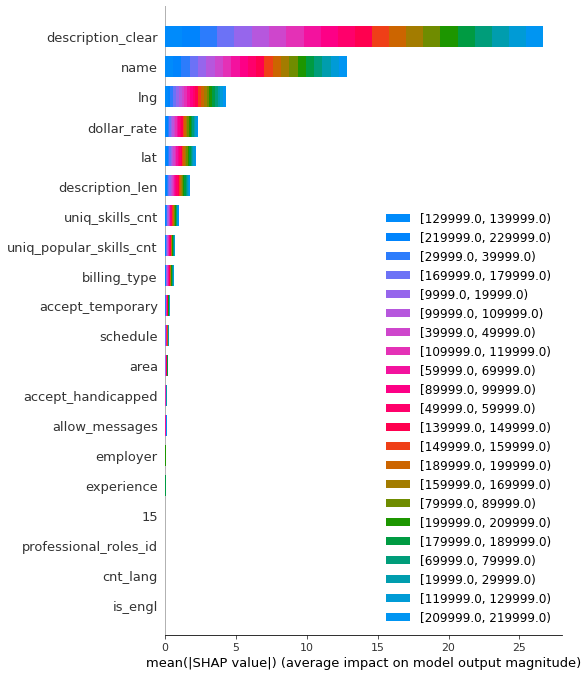

In [64]:
import shap
import catboost
explainer = shap.KernelExplainer(model.predict_proba, datasets['train'])
#shap_values = explainer.shap_values(X_train) # does not work with current shap version if using a catboost classifier
shap_values = model.get_feature_importance(pools['train'], type=catboost.EFstrType.ShapValues)  # can use 'ShapValues' instead for the type, and categorical_columns is the list of the columns names where the values are categorical

# visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=features['features'], out_names=np.unique(pools['test'].get_label()))

# summarize the effects of all the features in a multi-class barplot
original_shape = shap_values.shape
shap_values_reshaped = shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=datasets['train'], class_names=np.unique(pools['train'].get_label()), plot_type='bar')

In [46]:
model.predict(pools['train'])

array([['[59999.0, 69999.0)'],
       ['[59999.0, 69999.0)'],
       ['[29999.0, 39999.0)'],
       ...,
       ['[39999.0, 49999.0)'],
       ['[39999.0, 49999.0)'],
       ['[89999.0, 99999.0)']], dtype=object)

In [83]:
z = model.predict_proba(pools['train'])[0]
np.exp(z) / np.sum(np.exp(z), axis=0)

array([0.04307222, 0.04260458, 0.04270458, 0.0426537 , 0.0426679 ,
       0.04257173, 0.04255022, 0.04255854, 0.04254827, 0.04256465,
       0.04255089, 0.04254622, 0.04255052, 0.04259934, 0.04280132,
       0.04335564, 0.10051374, 0.04432405, 0.04305896, 0.04363108,
       0.04254681, 0.04302505])

In [96]:
model.predict(pools['train'], prediction_type='RawFormulaVal')[0]

array([ 0.0932215 , -2.08547625, -1.09868885, -1.48281871, -1.35992255,
       -2.89199016, -4.56644781, -3.58124261, -5.06340136, -3.20277832,
       -4.4393566 , -6.20723839, -4.50681704, -2.17776002, -0.62533008,
        0.52031123,  4.33943387,  1.29539311,  0.06789163,  0.80971541,
       -5.72534   ,  0.        ])

In [2]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pools['train'])

# abra = datasets['train'].iloc[0,:]
# abra['name'] = 'name'
# abra['description_clear'] = 'desc'

NameError: name 'model' is not defined

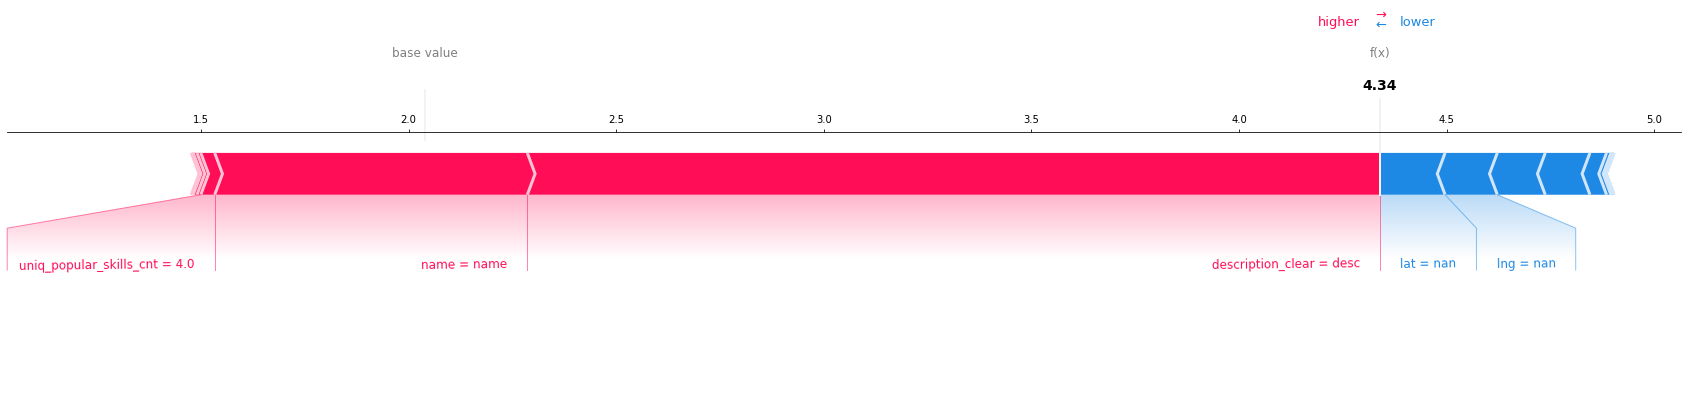

In [130]:
import matplotlib.pyplot as plt
shap.plots.force(explainer.expected_value[16], shap_values[16][0,:], abra, matplotlib=True, figsize=(30, 5), text_rotation=0.7, contribution_threshold=0.02, show=False).savefig('scratch.pdf',format = "pdf",dpi = 700,bbox_inches = 'tight')

# Добавляем росстат

In [41]:
city_mapping = pd.read_csv('../data/city_mapping.csv')
x = pd.read_csv('../data/dataset.csv')[['item_id', 'area_id']]
x.drop_duplicates(subset=['item_id'], inplace=True)
df = df.merge(x[['area_id', 'item_id']], how='left', on='item_id')
df = df.merge(city_mapping[['area_id', 'out']], how='left', on='area_id')
pathes = []
root = '../data/info-stat/'
for directory in os.listdir(root):
    for file in os.listdir(root + directory):
        # print(root + directory + '/' + file)
        pathes.append(root + directory + '/' + file)

df2 = pd.DataFrame(df['out'].unique(), columns=['out'])
for i, path in enumerate(pathes[:]):
    print(i, path)
    rosstat = pd.read_excel(path)
    columns = ['out'] + [f'feature_{i}{k}'for k in range(len(rosstat.columns[1:]))]
    rosstat.columns = columns
    rosstat = rosstat[columns].sort_values(columns).drop_duplicates(['out'], keep='first')
    rosstat['out'] = rosstat['out'].str.strip() # в некоторых колонках есть пробелы на конце
    rosstat['out'] = rosstat['out'].apply(
        lambda x: ' '.join(
            [re.sub(r'[0-9]', '', xx) for xx in x.split()]
            )
    )
    rosstat['out'] = rosstat['out'].str.replace(':', ',')
    for c in columns[1:]:
        rosstat[c] = rosstat[c].astype(str)
        rosstat[c] = pd.to_numeric(rosstat[c], errors='coerce')
    df2 = df2.merge(rosstat, on=['out'], how='left')

c:\Users\maksk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


0 ../data/info-stat/01 промышленность/01-01 индекс промышленного производства.xls
1 ../data/info-stat/01 промышленность/01-02 добыча полезных ископаемых.xls
2 ../data/info-stat/01 промышленность/01-03 обрабатывающие производства.xls
3 ../data/info-stat/01 промышленность/01-04 обеспечение электр.энергией, газом и паром кондиционирование воздуха.xls
4 ../data/info-stat/01 промышленность/01-05 водоснабжение  водоотведение  организация сбора  и утилизация отходов.xls
5 ../data/info-stat/01 промышленность/01-06 отгрузка товаров.xls
6 ../data/info-stat/01 промышленность/01-07 отгрузка-Рыболовство, рыбоводство.xls
7 ../data/info-stat/01 промышленность/01-11 производство электроэнергии.xls
8 ../data/info-stat/02 сельское хозяйство/02-01 Индексы сельского хозяйства.xls
9 ../data/info-stat/03 строительство/03-01 объем работ выполненных по ВЭД Строительство.xlsx
10 ../data/info-stat/03 строительство/03-02 строительство жилых домов.xls
11 ../data/info-stat/04 транспорт/04-01 Перевозка грузов и гру

In [42]:
df2 = df2.drop_duplicates(subset='out')
new_features = list(df2.columns[1:])
df = df.merge(df2, how='left', on = 'out')

In [150]:
features['features'] += new_features

In [132]:
model, pools, datasets, cr = train(df, features)

(109936, 76)
Learning rate set to 0.141591
0:	learn: 2.7371948	test: 2.7236173	best: 2.7236173 (0)	total: 443ms	remaining: 11m 4s
50:	learn: 1.7946950	test: 1.7627591	best: 1.7627591 (50)	total: 5.09s	remaining: 2m 24s
100:	learn: 1.7164654	test: 1.6984323	best: 1.6984323 (100)	total: 9.21s	remaining: 2m 7s
150:	learn: 1.6710069	test: 1.6680112	best: 1.6680112 (150)	total: 13.3s	remaining: 1m 58s
200:	learn: 1.6382867	test: 1.6501197	best: 1.6501197 (200)	total: 17.4s	remaining: 1m 52s
250:	learn: 1.6112816	test: 1.6377528	best: 1.6377528 (250)	total: 21.4s	remaining: 1m 46s
300:	learn: 1.5903891	test: 1.6286171	best: 1.6286171 (300)	total: 25.4s	remaining: 1m 41s
350:	learn: 1.5711842	test: 1.6212561	best: 1.6212561 (350)	total: 29.3s	remaining: 1m 35s
400:	learn: 1.5521434	test: 1.6149629	best: 1.6149629 (400)	total: 33.3s	remaining: 1m 31s
450:	learn: 1.5327969	test: 1.6092520	best: 1.6092520 (450)	total: 37.4s	remaining: 1m 27s
500:	learn: 1.5151700	test: 1.6044140	best: 1.6044140 

In [137]:
pd.set_option('display.max_rows', None)
pd.DataFrame({
    'feature_name': model.feature_names_,
    'feature_importance': model.feature_importances_
}).sort_values(by='feature_importance', ascending=False)

,feature_name,feature_importance
15,description_clear,49.858853
2,name,15.163794
8,employer,3.515402
54,feature_290,3.175480
5,experience,2.855201
19,professional_roles_id,2.627174
12,lng,1.900758
3,area,1.710342
1,schedule,1.601126
62,feature_370,1.388134


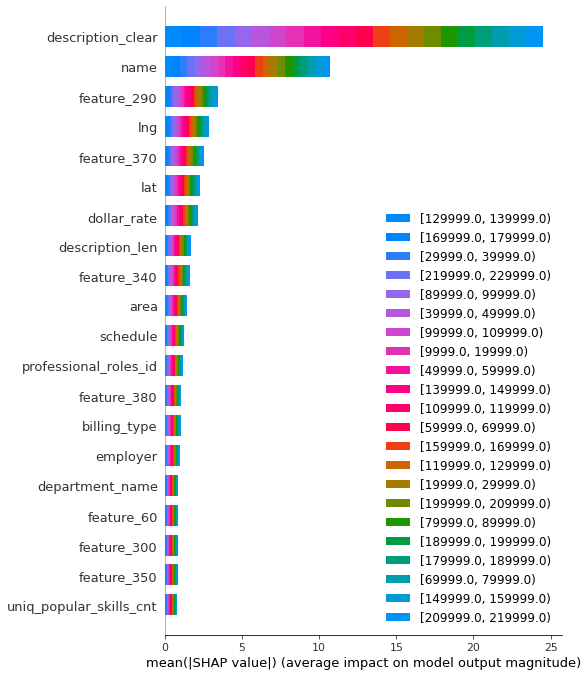

In [133]:
explainer = shap.KernelExplainer(model.predict_proba, datasets['train'])
#shap_values = explainer.shap_values(X_train) # does not work with current shap version if using a catboost classifier
shap_values = model.get_feature_importance(pools['train'], type=catboost.EFstrType.ShapValues)  # can use 'ShapValues' instead for the type, and categorical_columns is the list of the columns names where the values are categorical

# visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=features['features'], out_names=np.unique(pools['test'].get_label()))

# summarize the effects of all the features in a multi-class barplot
original_shape = shap_values.shape
shap_values_reshaped = shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=datasets['train'], class_names=np.unique(pools['train'].get_label()), plot_type='bar')

In [141]:
z = pd.DataFrame({
    'feature_name': model.feature_names_,
    'feature_importance': model.feature_importances_
}).sort_values(by='feature_importance', ascending=False)
z = z[z.feature_importance > 0.15]['feature_name'].values.tolist()

In [154]:
features['features'] = list(set(z) & set(features['features'])) + ['label']
features['cat_features'] = list(set(z) & set(features['cat_features']))
features['text_features'] = list(set(z) & set(features['text_features']))

In [155]:
model, pools, datasets, cr = train(df, features)

(109936, 47)
Learning rate set to 0.141591
0:	learn: 2.7371954	test: 2.7236171	best: 2.7236171 (0)	total: 354ms	remaining: 8m 50s
50:	learn: 1.7981897	test: 1.7667845	best: 1.7667845 (50)	total: 5s	remaining: 2m 22s
100:	learn: 1.7186453	test: 1.7026093	best: 1.7026093 (100)	total: 9.29s	remaining: 2m 8s
150:	learn: 1.6693994	test: 1.6688321	best: 1.6688321 (150)	total: 13.6s	remaining: 2m 1s
200:	learn: 1.6373950	test: 1.6512623	best: 1.6512623 (200)	total: 17.8s	remaining: 1m 55s
250:	learn: 1.6115086	test: 1.6401368	best: 1.6401368 (250)	total: 22s	remaining: 1m 49s
300:	learn: 1.5877057	test: 1.6301969	best: 1.6301969 (300)	total: 26.2s	remaining: 1m 44s
350:	learn: 1.5674264	test: 1.6228043	best: 1.6228043 (350)	total: 30.3s	remaining: 1m 39s
400:	learn: 1.5488253	test: 1.6166358	best: 1.6166358 (400)	total: 34.3s	remaining: 1m 34s
450:	learn: 1.5295008	test: 1.6096572	best: 1.6096572 (450)	total: 38.6s	remaining: 1m 29s
500:	learn: 1.5126717	test: 1.6051746	best: 1.6051746 (500)	

In [156]:
pd.set_option('display.max_rows', None)
pd.DataFrame({
    'feature_name': model.feature_names_,
    'feature_importance': model.feature_importances_
}).sort_values(by='feature_importance', ascending=False)

,feature_name,feature_importance
40,description_clear,49.394144
41,name,15.385191
38,employer,4.372297
23,feature_290,3.289969
12,experience,2.903552
7,professional_roles_id,2.635836
0,area,1.849950
32,lng,1.747796
13,feature_370,1.662667
24,schedule,1.519449


In [157]:
# features_290, features_370

In [43]:
array = []
with open('../data/similar_vac.txt', 'r') as f:
    raws = f.readlines()
    for raw in tqdm(raws):
        raw = raw.replace('\n', '')
        array.append(raw.split('\t'))
array = pd.DataFrame(array, columns=['item_id', 'mean_similar', 'min_similar', 'max_similar'])
array = array.astype(np.float64)
df = df.merge(array, on='item_id', how='left')

100%|██████████| 157044/157044 [00:00<00:00, 451175.34it/s]


In [224]:
features = {
    'features': [
        'billing_type',
        'schedule',
        'name',
        'area',
        'allow_messages',
        'experience',
        'accept_handicapped',
        'accept_kids',
        'employer',
        'accept_temporary',
        '15',
        'lat',
        'lng',
        'department_name',
        'has_department',
        'description_clear',
        'description_len',
        'uniq_skills_cnt',
        'uniq_popular_skills_cnt',
        'professional_roles_id',
        'dollar_rate',
        'is_engl',
        'is_ger',
        'is_chi',
        'cnt_lang',
        'label',
    ],
    'cat_features': [
        'billing_type',
        'schedule',
        'area',
        'experience',
        'employer',
        '15',
        'department_name',
        'professional_roles_id'
    ],
    'text_features': [
        'name',
        'description_clear'
    ]
}
features['features'] += ['mean_similar', 'min_similar', 'max_similar', 'feature_290', 'feature_370']

In [226]:
model, pools, datasets, cr = train(df, features, device='GPU')

(109936, 30)
Learning rate set to 0.141591
0:	learn: 2.6197165	test: 2.6113742	best: 2.6113742 (0)	total: 246ms	remaining: 6m 8s
50:	learn: 1.5720520	test: 1.5479467	best: 1.5479467 (50)	total: 4.33s	remaining: 2m 2s
100:	learn: 1.4828532	test: 1.4685933	best: 1.4685933 (100)	total: 8.39s	remaining: 1m 56s
150:	learn: 1.4377671	test: 1.4355003	best: 1.4355003 (150)	total: 12.4s	remaining: 1m 50s
200:	learn: 1.4074311	test: 1.4163778	best: 1.4163778 (200)	total: 16.4s	remaining: 1m 46s
250:	learn: 1.3831714	test: 1.4035940	best: 1.4035940 (250)	total: 20.2s	remaining: 1m 40s
300:	learn: 1.3604712	test: 1.3930330	best: 1.3930330 (300)	total: 24.1s	remaining: 1m 36s
350:	learn: 1.3413880	test: 1.3843696	best: 1.3843696 (350)	total: 28s	remaining: 1m 31s
400:	learn: 1.3239966	test: 1.3776933	best: 1.3776933 (400)	total: 31.8s	remaining: 1m 27s
450:	learn: 1.3062511	test: 1.3711762	best: 1.3711762 (450)	total: 35.8s	remaining: 1m 23s
500:	learn: 1.2904268	test: 1.3663578	best: 1.3663578 (50

In [227]:
pd.set_option('display.max_rows', None)
pd.DataFrame({
    'feature_name': model.feature_names_,
    'feature_importance': model.feature_importances_
}).sort_values(by='feature_importance', ascending=False)

,feature_name,feature_importance
15,description_clear,41.150894
25,mean_similar,18.188551
2,name,11.795772
26,min_similar,4.133840
27,max_similar,3.374638
8,employer,3.167524
3,area,2.354860
19,professional_roles_id,2.175559
28,feature_290,2.067631
5,experience,1.946981


In [228]:
model.save_model('../app/model/base.cbm')

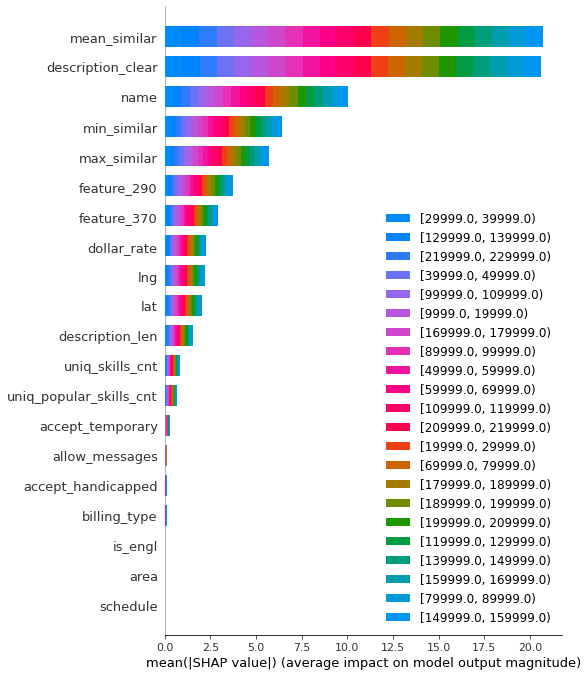

In [169]:
explainer = shap.KernelExplainer(model.predict_proba, datasets['train'])
#shap_values = explainer.shap_values(X_train) # does not work with current shap version if using a catboost classifier
shap_values = model.get_feature_importance(pools['train'], type=catboost.EFstrType.ShapValues)  # can use 'ShapValues' instead for the type, and categorical_columns is the list of the columns names where the values are categorical

# visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=features['features'], out_names=np.unique(pools['test'].get_label()))

# summarize the effects of all the features in a multi-class barplot
original_shape = shap_values.shape
shap_values_reshaped = shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=datasets['train'], class_names=np.unique(pools['train'].get_label()), plot_type='bar')

In [171]:
model.predict(pools['train'])

array([['[59999.0, 69999.0)'],
       ['[69999.0, 79999.0)'],
       ['[39999.0, 49999.0)'],
       ...,
       ['[49999.0, 59999.0)'],
       ['[29999.0, 39999.0)'],
       ['[109999.0, 119999.0)']], dtype=object)

In [234]:
# xx = joblib.load(ex_filename)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


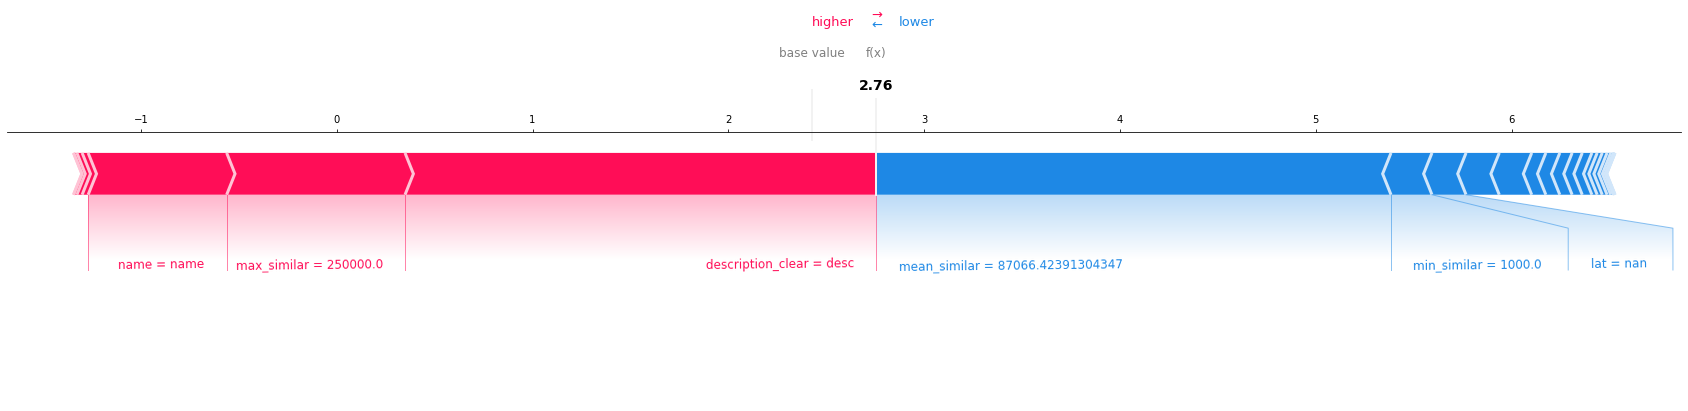

In [229]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pools['train'])

abra = datasets['train'].iloc[0,:]
abra['name'] = 'name'
abra['description_clear'] = 'desc'

import matplotlib.pyplot as plt
shap.plots.force(explainer.expected_value[16], shap_values[16][0,:], abra, matplotlib=True, figsize=(100, 5), text_rotation=0.7, contribution_threshold=0.02, show=False).savefig('scratch.pdf',format = "pdf",dpi = 700,bbox_inches = 'tight')

In [ ]:
import joblib
ex_filename = '../app/explainer.bz2'
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))

In [231]:
explainer.expected_value

[-0.06114853813441619,
 -1.8634718227876885,
 -1.5770964085845949,
 -2.8395844573018887,
 -2.6524179632380522,
 -2.0978059951591375,
 -5.457701860082485,
 -4.815281401417609,
 -5.087250282744249,
 0.5428697300938438,
 -4.408323787716666,
 -6.467380306636324,
 -3.8957188349472545,
 2.2038603357162536,
 2.600821700494902,
 3.105669086442097,
 2.4272673683765427,
 1.7636290485104054,
 0.471297373477129,
 0.8959489861057831,
 -2.0598379828121267,
 0.0]

In [180]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

In [208]:
X_train, X_valid, y_train, y_valid = train_test_split(df[features['features']].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

In [209]:
X_train.drop(features['text_features'], axis=1, inplace=True)
X_valid.drop(features['text_features'], axis=1, inplace=True)
X_test.drop(features['text_features'], axis=1, inplace=True)

In [210]:
encoder = preprocessing.OrdinalEncoder()
encoder.set_params(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train[features['cat_features']])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [211]:
X_train[features['cat_features']] = encoder.transform(X_train[features['cat_features']])
X_valid[features['cat_features']] = encoder.transform(X_valid[features['cat_features']])
X_test[features['cat_features']] = encoder.transform(X_test[features['cat_features']])

In [212]:
X_train = X_train.fillna(-1)
X_valid = X_valid.fillna(-1)
X_test = X_test.fillna(-1)

In [213]:
tree = DecisionTreeClassifier(max_depth=7)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [216]:
print(classification_report(y_test, tree.predict(X_test), output_dict=False))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                      precision    recall  f1-score   support

[109999.0, 119999.0)       0.26      0.41      0.32       998
[119999.0, 129999.0)       0.00      0.00      0.00       328
[129999.0, 139999.0)       0.20      0.30      0.24       425
[139999.0, 149999.0)       0.00      0.00      0.00       214
[149999.0, 159999.0)       0.00      0.00      0.00       201
[159999.0, 169999.0)       0.23      0.57      0.33       375
[169999.0, 179999.0)       0.00      0.00      0.00        28
[179999.0, 189999.0)       0.00      0.00      0.00        66
[189999.0, 199999.0)       0.20      0.02      0.03        56
  [19999.0, 29999.0)       0.62      0.34      0.44      1841
[199999.0, 209999.0)       0.00      0.00      0.00       111
[209999.0, 219999.0)       0.00      0.00      0.00        18
[219999.0, 229999.0)       0.31      0.21      0.25       131
  [29999.0, 39999.0)       0.37      0.68      0.48      3803
  [39999.0, 49999.0)       0.50      0.28      0.36      3226
  [4999

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [217]:
from sklearn.ensemble import RandomForestClassifier

In [220]:
tree = RandomForestClassifier(max_depth=15, n_estimators=100,)
tree.fit(X_train, y_train)

RandomForestClassifier(max_depth=15)

In [221]:
print(classification_report(y_test, tree.predict(X_test), output_dict=False))

                      precision    recall  f1-score   support

[109999.0, 119999.0)       0.31      0.52      0.39       998
[119999.0, 129999.0)       0.53      0.19      0.28       328
[129999.0, 139999.0)       0.38      0.24      0.30       425
[139999.0, 149999.0)       0.54      0.21      0.30       214
[149999.0, 159999.0)       0.50      0.12      0.19       201
[159999.0, 169999.0)       0.32      0.53      0.40       375
[169999.0, 179999.0)       1.00      0.07      0.13        28
[179999.0, 189999.0)       0.54      0.23      0.32        66
[189999.0, 199999.0)       0.92      0.39      0.55        56
  [19999.0, 29999.0)       0.64      0.43      0.51      1841
[199999.0, 209999.0)       0.67      0.27      0.38       111
[209999.0, 219999.0)       1.00      0.06      0.11        18
[219999.0, 229999.0)       0.57      0.41      0.48       131
  [29999.0, 39999.0)       0.49      0.67      0.57      3803
  [39999.0, 49999.0)       0.52      0.36      0.42      3226
  [4999

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange

from transformers import BertPreTrainedModel, BertModel, AutoModelForSequenceClassification
from transformers import AutoConfig, AutoTokenizer, BertConfig


In [16]:
class DescriptionDataset(Dataset):

    def __init__(self, data, maxlen, tokenizer): 
        #Store the contents of the file in a pandas dataframe
        self.df = data.reset_index()
        #Initialize the tokenizer for the desired transformer model
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):    
        #Select the sentence and label at the specified index in the data frame
        excerpt = self.df.loc[index, 'description_clear']
        try:
            target = self.df.loc[index, 'salary_from_rate_and_gross_log']
        except:
            target = 0.0
        identifier = self.df.loc[index, 'index']
        #Preprocess the text to be suitable for the transformer
        tokens = self.tokenizer.tokenize(excerpt) 
        tokens = ['[CLS]'] + tokens + ['[SEP]'] 
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] 
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] 
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
        input_ids = torch.tensor(input_ids) 
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()
        
        target = torch.tensor(target, dtype=torch.float32)
        
        return input_ids, attention_mask, target

In [17]:
class DescriptionDataset(Dataset):

    def __init__(self, data, maxlen, tokenizer): 
        #Store the contents of the file in a pandas dataframe
        self.df = data.reset_index()
        #Initialize the tokenizer for the desired transformer model
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):    
        #Select the sentence and label at the specified index in the data frame
        excerpt = self.df.loc[index, 'description_clear']
        try:
            target = self.df.loc[index, 'salary_from_rate_and_gross_log']
        except:
            target = 0.0
        identifier = self.df.loc[index, 'index']
        #Preprocess the text to be suitable for the transformer
        tokens = self.tokenizer.tokenize(excerpt) 
        tokens = ['[CLS]'] + tokens + ['[SEP]'] 
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] 
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] 
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
        input_ids = torch.tensor(input_ids) 
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()
        
        target = torch.tensor(target, dtype=torch.float32)
        
        return input_ids, attention_mask, target

In [18]:
class BertRegresser(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        #The output layer that takes the [CLS] representation and gives an output
        self.cls_layer1 = nn.Linear(config.hidden_size,128)
        self.relu1 = nn.ReLU()
        self.ff1 = nn.Linear(128,128)
        self.tanh1 = nn.Tanh()
        self.ff2 = nn.Linear(128,1)

    def forward(self, input_ids, attention_mask):
        #Feed the input to Bert model to obtain contextualized representations
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        logits = outputs.last_hidden_state[:,0,:]
        output = self.cls_layer1(logits)
        output = self.relu1(output)
        output = self.ff1(output)
        output = self.tanh1(output)
        output = self.ff2(output)
        return output, outputs

In [19]:
config = BertConfig.from_pretrained("cointegrated/rubert-tiny", output_hidden_states=True)
bert = BertRegresser.from_pretrained("cointegrated/rubert-tiny", config=config)
bert.load_state_dict(torch.load('../bert/bert regression/regression_model/third.pth'))

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertRegresser: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertRegresser from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertRegresser from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertRegresser were not initialized from the model checkpoint at cointegrated/rubert-tiny

<All keys matched successfully>

In [20]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
df_set = DescriptionDataset(data=df[['description_clear']], maxlen=256, tokenizer=tokenizer)

In [21]:
bert.cuda()
bert.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

array = []

with torch.no_grad():
    for dataset in tqdm(df_set):
        output = bert(dataset[0].to(device).unsqueeze(0), dataset[1].to(device).unsqueeze(0))
        output = output[1]['last_hidden_state'][0, 0, :].detach().cpu().numpy()
        array.append(output)
        # break

100%|██████████| 157052/157052 [11:04<00:00, 236.40it/s]


KeyError: 157052

In [22]:
array.__len__()

157052

In [23]:
df['description_emb'] = pd.Series(array)

In [30]:
features = {
    'features': [
        'billing_type',
        'schedule',
        'name',
        'area',
        'allow_messages',
        'experience',
        'accept_handicapped',
        'accept_kids',
        'employer',
        'accept_temporary',
        '15',
        'lat',
        'lng',
        'department_name',
        'has_department',
        # 'description_clear',
        'description_len',
        'uniq_skills_cnt',
        'uniq_popular_skills_cnt',
        'professional_roles_id',
        'dollar_rate',
        'is_engl',
        'is_ger',
        'is_chi',
        'cnt_lang',
        'label',
    ],
    'cat_features': [
        'billing_type',
        'schedule',
        'area',
        'experience',
        'employer',
        '15',
        'department_name',
        'professional_roles_id'
    ],
    'text_features': [
        'name',
        # 'description_clear'
    ],
    'embedding_features': [
        'description_emb'
    ]
}
features['features'] += ['mean_similar', 'min_similar', 'max_similar', 'feature_290', 'feature_370', 'description_emb']

In [31]:
def pool(data, label, cat_features, text_features, embedding_features):
    return Pool(
        data=data,
        label=label,
        cat_features=cat_features,
        text_features=text_features,
        embedding_features=embedding_features
    )

def train(df:pd.DataFrame, features:dict, device='GPU'):
    cat_features = features['cat_features']
    text_features = features['text_features']
    embedding_features = features['embedding_features']
    features = features['features']
    X_train, X_valid, y_train, y_valid = train_test_split(df[features].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

    pools = {}
    print(X_train.shape)
    pools['train'] = pool(X_train, y_train, cat_features, text_features, embedding_features)
    pools['valid'] = pool(X_valid, y_valid, cat_features, text_features, embedding_features)
    pools['test'] = pool(X_test, y_test, cat_features, text_features, embedding_features)
    model = CatBoostClassifier(iterations = 1_500, task_type=device)
    model.fit(
        pools['train'],
        eval_set=pools['valid'],
        use_best_model=True,
        plot=False,
        verbose=50,
        early_stopping_rounds=50,
    )
    datasets = {
        'train': X_train,
        'valid': X_valid,
        'test': X_test
    }
    y_pred = model.predict(pools['test'])
    cr = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred, output_dict=False))
    return model, pools, datasets, cr

In [32]:
model, pools, datasets, cr = train(df, features)

(109936, 30)
Learning rate set to 0.141591
0:	learn: 2.6188896	test: 2.6138558	best: 2.6138558 (0)	total: 262ms	remaining: 6m 32s
50:	learn: 1.6174608	test: 1.5826429	best: 1.5826429 (50)	total: 6.36s	remaining: 3m
100:	learn: 1.5337317	test: 1.5108736	best: 1.5108736 (100)	total: 15.2s	remaining: 3m 30s
150:	learn: 1.4926581	test: 1.4802686	best: 1.4802686 (150)	total: 24.9s	remaining: 3m 42s
200:	learn: 1.4651770	test: 1.4632178	best: 1.4632178 (200)	total: 35.4s	remaining: 3m 48s
250:	learn: 1.4431585	test: 1.4521137	best: 1.4521137 (250)	total: 43s	remaining: 3m 34s
300:	learn: 1.4265627	test: 1.4450102	best: 1.4450102 (300)	total: 50.8s	remaining: 3m 22s
350:	learn: 1.4114284	test: 1.4406251	best: 1.4406251 (350)	total: 56s	remaining: 3m 3s
400:	learn: 1.3925780	test: 1.4323278	best: 1.4323278 (400)	total: 1m 3s	remaining: 2m 53s
450:	learn: 1.3788561	test: 1.4288692	best: 1.4288692 (450)	total: 1m 8s	remaining: 2m 39s
500:	learn: 1.3678525	test: 1.4266990	best: 1.4266990 (500)	to

In [33]:
pd.set_option('display.max_rows', None)
pd.DataFrame({
    'feature_name': model.feature_names_,
    'feature_importance': model.feature_importances_
}).sort_values(by='feature_importance', ascending=False)

,feature_name,feature_importance
24,mean_similar,22.334510
2,name,19.792752
29,description_emb,10.334455
8,employer,6.887013
25,min_similar,6.157434
26,max_similar,3.975357
3,area,3.616166
18,professional_roles_id,3.404496
5,experience,3.080966
15,description_len,2.996214


In [46]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
stop_words = stopwords.words('russian')

In [75]:
import spacy
nlp = spacy.load('ru_core_news_sm', disable=['parser', 'ner'])

def lemmatize(data):
    doc = nlp(data)
    array = []
    for token in doc:
        array.append(token.lemma_)
    return ' '.join(array)

In [76]:
tqdm.pandas()

In [77]:
df['description_clear_lemm'] = df.description_clear.progress_apply(lemmatize)

100%|██████████| 157052/157052 [1:48:47<00:00, 24.06it/s] 


In [80]:
# df.to_csv('dataset_final.csv', index=False)

In [14]:
df = pd.read_csv('dataset_final.csv')

c:\Users\maksk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [105]:
vectorizer = TfidfVectorizer(max_features=300, stop_words=stop_words, min_df=100)
tfidf_array = np.array(vectorizer.fit_transform(df['description_clear_lemm']).todense(), dtype=np.float32)

In [106]:
vectorizer.get_feature_names_out()

array(['000', '10', '1700', '1800', '1с', '22', '3х', '52', '800', '900',
       'excel', 'автомобиль', 'активный', 'анализ', 'аналогичный', 'база',
       'банк', 'безопасность', 'белый', 'бесплатный', 'больничный',
       'больший', 'вакансия', 'ваш', 'ведение', 'вести', 'весь',
       'взаимодействие', 'вид', 'владение', 'внимательность',
       'внутренний', 'возможность', 'возможный', 'вопрос', 'время',
       'входить', 'выплата', 'выполнение', 'высокий', 'выходной', 'год',
       'город', 'гость', 'готовность', 'готовый', 'грамотный', 'график',
       'группа', 'данных', 'действовать', 'делать', 'дело', 'день',
       'деятельность', 'дмс', 'договор', 'документ', 'документация',
       'должность', 'дом', 'дополнительный', 'доставка', 'доход',
       'дружный', 'ждать', 'желание', 'жильё', 'задача', 'заказ',
       'заказчик', 'законодательство', 'заниматься', 'заработный',
       'зарплата', 'заявка', 'знание', 'зп', 'иметь', 'инструмент',
       'интересный', 'информация', 'ис

In [107]:
# tfidf_array = np.delete(tfidf_array, [0, 1, 2, 3, 5, 7, 8, 9], 1)
# columns = np.delete(vectorizer.get_feature_names_out(), [0, 1, 2, 3, 5, 7, 8, 9])

In [108]:
tfidf_features = []
for i in range(len(columns)):
    df.loc[:, 'description_tfidf_' + columns[i]] = tfidf_array[:, i]
    tfidf_features.append('description_tfidf_' + columns[i])

In [109]:
def pool(data, label, cat_features, text_features):
    return Pool(
        data=data,
        label=label,
        cat_features=cat_features,
        text_features=text_features,
    )

def train(df:pd.DataFrame, features:dict, device='GPU'):
    cat_features = features['cat_features']
    text_features = features['text_features']
    features = features['features']
    X_train, X_valid, y_train, y_valid = train_test_split(df[features].drop(['label'], axis=1), df['label'], test_size=0.3, random_state=0, stratify=df['label'])
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0, stratify=y_valid)

    pools = {}
    print(X_train.shape)
    pools['train'] = pool(X_train, y_train, cat_features, text_features)
    pools['valid'] = pool(X_valid, y_valid, cat_features, text_features)
    pools['test'] = pool(X_test, y_test, cat_features, text_features)
    model = CatBoostClassifier(iterations = 1_500, task_type=device)
    model.fit(
        pools['train'],
        eval_set=pools['valid'],
        use_best_model=True,
        plot=False,
        verbose=50,
        early_stopping_rounds=50,
    )
    datasets = {
        'train': X_train,
        'valid': X_valid,
        'test': X_test
    }
    y_pred = model.predict(pools['test'])
    cr = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred, output_dict=False))
    return model, pools, datasets, cr

In [110]:
features = {
    'features': [
        'billing_type',
        'schedule',
        'name',
        'area',
        'allow_messages',
        'experience',
        'accept_handicapped',
        'accept_kids',
        'employer',
        'accept_temporary',
        '15',
        'lat',
        'lng',
        'department_name',
        'has_department',
        # 'description_clear',
        'description_len',
        'uniq_skills_cnt',
        'uniq_popular_skills_cnt',
        'professional_roles_id',
        'dollar_rate',
        'is_engl',
        'is_ger',
        'is_chi',
        'cnt_lang',
        'label',
    ],
    'cat_features': [
        'billing_type',
        'schedule',
        'area',
        'experience',
        'employer',
        '15',
        'department_name',
        'professional_roles_id'
    ],
    'text_features': [
        'name',
        # 'description_clear'
    ]
}
features['features'] += ['mean_similar', 'min_similar', 'max_similar', 'feature_290', 'feature_370'] 
features['features'] += tfidf_features

In [111]:
model, pools, datasets, cr = train(df, features)

(109936, 321)
Learning rate set to 0.141591
0:	learn: 2.6188893	test: 2.6138560	best: 2.6138560 (0)	total: 362ms	remaining: 9m 2s
50:	learn: 1.6194073	test: 1.6085471	best: 1.6085471 (50)	total: 11.3s	remaining: 5m 20s
100:	learn: 1.5443043	test: 1.5481509	best: 1.5481509 (100)	total: 16.5s	remaining: 3m 49s
150:	learn: 1.5035941	test: 1.5214736	best: 1.5214736 (150)	total: 21.5s	remaining: 3m 11s
200:	learn: 1.4730245	test: 1.5033609	best: 1.5033609 (200)	total: 26.6s	remaining: 2m 52s
250:	learn: 1.4454484	test: 1.4891572	best: 1.4891572 (250)	total: 31.8s	remaining: 2m 38s
300:	learn: 1.4229373	test: 1.4786440	best: 1.4786440 (300)	total: 36.8s	remaining: 2m 26s
350:	learn: 1.4021121	test: 1.4700037	best: 1.4700037 (350)	total: 41.7s	remaining: 2m 16s
400:	learn: 1.3820663	test: 1.4623454	best: 1.4623454 (400)	total: 46.9s	remaining: 2m 8s
450:	learn: 1.3618034	test: 1.4554096	best: 1.4554096 (450)	total: 52.2s	remaining: 2m 1s
500:	learn: 1.3432116	test: 1.4496235	best: 1.4496235 (

In [112]:
pd.set_option('display.max_rows', None)
pd.DataFrame({
    'feature_name': model.feature_names_,
    'feature_importance': model.feature_importances_
}).sort_values(by='feature_importance', ascending=False)

,feature_name,feature_importance
24,mean_similar,17.040600
2,name,13.584092
25,min_similar,4.549467
26,max_similar,3.323864
8,employer,3.220011
5,experience,2.225051
18,professional_roles_id,2.144187
27,feature_290,2.059891
3,area,2.034254
28,feature_370,1.455338
